In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from enum import Enum
import sys


## Used Dataset

We used the dataset CIFAR10 for training and testing our neural networks. The dataset consists of a total of 60000 colour images, which are split into 50000 training images and 10000 test images. Each image has a resolution of 32x32 pixel. 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.  
The Training set is further split into 5 Batches à 10000 images. Each training batch can have a different amount of pictures from the ten classes, whereas the test-set contains exactly 1000 pictures of each class.
Following Classes are available:  
    * airplane
    * automobile
    * bird
    * cat
    * deer
    * dog
    * frog
    * horse
    * ship
    * truck
    
The following images shows an example for all the classes and 10 random images:
<img src="CIFAR-10-example.PNG" width="450px" alt="CIFAR-10 example" title="CIFAR-10 example images" />

Torchvision datasets are PILImage images in range [0, 1]<br>
=> transform them to normalized Tensors in range [-1, 1].



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # image = (image - mean) / std
     ])

class NeuralNet(Enum):
    Net = 1
    ResNet34 = 2
    ResNet50 = 3
    
#select network to be used for training
network = NeuralNet.Net

# labels of the ten classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

examplesCnt = 8 # how many sample images with ground truth/prediction shall be printed

batchSize = 200 # utilize parallel processing power of GPU, further increasing this number doesn't seem to have any effect

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


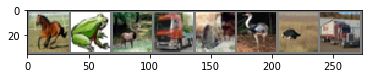

horse,  frog,  deer, truck,   cat,  bird,  bird, truck


In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# get some random training images
images, labels = iter(trainloader).next()
images = images[0:examplesCnt]
labels = labels[0:examplesCnt]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(', '.join('%5s' % classes[labels[j]] for j in range(examplesCnt)))

## Defining the neural networks:

We decided to use 3 networks and compare the results each network gives.

Note: We adapted the learning rate for all networks, the exact approach will be noted for the optimizer

<b> Convulutional neural network </b>
As a starter we used the Convolutional neural network from pytorch (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). We did not use an exact copy, but tried to optimize and increase the speed of the training process.
In order to increase speed we raised the batch-size from originally 4 to 200. We stopped at 200 because there was no further improvment regarding the computation time.
In order to adapt to the new batch-size we had to increase our learning rate(originally 0.001). Since the optimizer now has more images for computing the gradient. Hence it's a better approximation needs a bigger learning rate in order to efficiently improve the result. Without a larger learning rate we would need way more epoches to compensate the more precise gradient. 

Additional we decided to increase the input and output layers for the convolutions. Our thoughtprocess behind this, was to increase accuracy. Looking at more features from a picture should increase learning accuracy and lead to a better result. We tried with increasing inputplanes and stopped once we stopped noticing improvment in accuracy.
Hence the following 3 computations changed:

<b>Network definition:</b>  
self.conv1 = nn.Conv2d(3, 6, 5) -> self.conv1 = nn.Conv2d(3, 48, 5)  
self.conv2 = nn.Conv2d(6, 16, 5) -> self.conv2 = nn.Conv2d(48, 64, 5)

<b>Forward-Step</b> (This change was necessary for the network to work, not for improvment. Otherwise the dimensions for the function would not match)  
x = x.view(-1, 16 * 5 * 5) -> x = x.view(-1, 64 * 5 * 5)

In [4]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, 
        out_planes, 
        kernel_size=1, 
        stride=stride, 
        #padding=0
        bias=False)

In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, 
                     out_planes, 
                     kernel_size=3, 
                     stride=stride,
                     padding=1, # with stride=1 this preserves dimension
                     bias=False)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2d: input, output, kernel size, (stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 48, 5) # 3 input image channel, 64 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(48, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 classses output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 48 channels: conv results in 28x28 (image-kernel+1), pool => 14x14 image size
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) # 64 channels: conv results in 10x10 (image-kernel+1), pool => 5x5 image size
        #print(x.shape)
        x = x.view(-1, 64 * 5 * 5)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Resnet Implementations

We choose two Resnet Implementations, ResNet-34 and Resnet-50. Since both use different Blocks 
(Resnet-34 uses BasicBlocks, Resnet-50 usese Bottleneck Blocks). Theses networks are not too far apart, regarding layer 
size, but use different kind of Blocks, so we were interested to see how this difference would impact accuracy and runtime.

### Resnet-34 BasisBlock

For the BasicBlock Implementation we used the lecture as a template.  

![BasicBlock](BasicBlock.png)

### Resnet-34

For the the Resnet-34 we tried to implement the network while using the paper as a model. We noticed, that the implementation from our paper is very similar to the one pytorch(same holds for Resnet-50). 
    * Each resnet useses either Basic- or BottleneckBlocks, but never both
    * Both use the same data processing technique (# TODO state these techniques)
    * Both use a Linear network in order to map the results to our ten classes
    
In the paper way more epoches are used than we could handle, since we are missing the computational power. Hence we tried to adjust the learning rate in order to achieve a fast but still accurate result. 
Tweaks we did #TODO

### Resnet-50 BottleneckBlock

For the BottleneckBlock we also used the template from the lecture.  

![BotleneckBlock](BottleneckBlock.png)

#### Resnet-50 

Tweaks we did #TODO
    

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        """
        3x3 convolution inplanes->outplanes 
        (spatial size maintained), BN + ReLU
        """ 
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        """
        3x3 convolution inplanes->outplanes 
        (spatial size maintained) + BN
        """ 
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # needed to fix dimension incompatibility
        self.stride = stride # not actually used in class itself
        self.downsample = downsample

    def forward(self, x):
        residual = x # preserve input for identity functionality

        # conv->bn->relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # conv->bn
        out = self.conv2(out)
        out = self.bn2(out)
        
        """
        At that point, we check if a downsampling needs to be 
        applied on x, such that F(x)+x can be computed.
        """
        if self.downsample is not None:
            residual = self.downsample(x)

        # shortcut connection: x + F(x)
        out += residual
        
        # building block ends with ReLU
        out = self.relu(out)

        return out


In [8]:
class Bottleneck(nn.Module):
    """
    The expansion factor controls the number of output 
    channels of the last 1x1 convolution layer.
    """
    expansion = 4  

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [9]:
# use cuda device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
# ResNet34 has a 3-4-6-3 structure of BasicBlocks
class ResNet34(nn.Module):

    def __init__(self, num_classes=10, zero_init_residual=False):
        super(ResNet34, self).__init__()
        
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        
        # layer 1: 3 times BasicBlock with 64 planes, no dimension increase
        planes = 64
        layers = []
        layers.append(BasicBlock(self.inplanes, planes, 1, None))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes))
        layers.append(BasicBlock(self.inplanes, planes))
        self.layer1 = nn.Sequential(*layers)
    
        # layer 2: 4 times BasicBlock with 128 planes, dimension increase!
        planes = 128
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * BasicBlock.expansion, stride=2), nn.BatchNorm2d(planes * BasicBlock.expansion) )
        layers.append(BasicBlock(self.inplanes, planes, 2, down_fn))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes))
        layers.append(BasicBlock(self.inplanes, planes))
        layers.append(BasicBlock(self.inplanes, planes))
        self.layer2 = nn.Sequential(*layers)
    
        # layer 3: 6 times BasicBlock with 256 planes, dimension increase!
        planes = 256
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * BasicBlock.expansion, stride=2), nn.BatchNorm2d(planes * BasicBlock.expansion) )
        layers.append(BasicBlock(self.inplanes, planes, 2, down_fn))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes))
        layers.append(BasicBlock(self.inplanes, planes))
        layers.append(BasicBlock(self.inplanes, planes))
        layers.append(BasicBlock(self.inplanes, planes))
        layers.append(BasicBlock(self.inplanes, planes))
        self.layer3 = nn.Sequential(*layers)
    
        # layer 4: 3 times BasicBlock with 512 planes, dimension increase!
        planes = 512
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * BasicBlock.expansion, stride=2), nn.BatchNorm2d(planes * BasicBlock.expansion) )
        layers.append(BasicBlock(self.inplanes, planes, 2, down_fn))
        self.inplanes = planes * BasicBlock.expansion
        layers.append(BasicBlock(self.inplanes, planes))
        layers.append(BasicBlock(self.inplanes, planes))
        self.layer4 = nn.Sequential(*layers)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        # ToDo
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # ToDo
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [11]:
# ResNet50 has a 3-4-6-3 structure of Bottlenecks
class ResNet50(nn.Module):

    def __init__(self, num_classes=10, zero_init_residual=False):
        super(ResNet50, self).__init__()
        
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        
        # layer 1: 3 times Bottleneck with 64 planes, no dimension increase
        planes = 64
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * Bottleneck.expansion, stride=1), nn.BatchNorm2d(planes * Bottleneck.expansion) )
        layers.append(Bottleneck(self.inplanes, planes, 1, down_fn))
        self.inplanes = planes * Bottleneck.expansion
        layers.append(Bottleneck(self.inplanes, planes))
        layers.append(Bottleneck(self.inplanes, planes))
        self.layer1 = nn.Sequential(*layers)
    
        # layer 2: 4 times Bottleneck with 128 planes, dimension increase!
        planes = 128
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * Bottleneck.expansion, stride=2), nn.BatchNorm2d(planes * Bottleneck.expansion) )
        layers.append(Bottleneck(self.inplanes, planes, 2, down_fn))
        self.inplanes = planes * Bottleneck.expansion
        layers.append(Bottleneck(self.inplanes, planes))
        layers.append(Bottleneck(self.inplanes, planes))
        layers.append(Bottleneck(self.inplanes, planes))
        self.layer2 = nn.Sequential(*layers)
    
        # layer 3: 6 times Bottleneck with 256 planes, dimension increase!
        planes = 256
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * Bottleneck.expansion, stride=2), nn.BatchNorm2d(planes * Bottleneck.expansion) )
        layers.append(Bottleneck(self.inplanes, planes, 2, down_fn))
        self.inplanes = planes * Bottleneck.expansion
        layers.append(Bottleneck(self.inplanes, planes))
        layers.append(Bottleneck(self.inplanes, planes))
        layers.append(Bottleneck(self.inplanes, planes))
        layers.append(Bottleneck(self.inplanes, planes))
        layers.append(Bottleneck(self.inplanes, planes))
        self.layer3 = nn.Sequential(*layers)
    
        # layer 4: 3 times Bottleneck with 512 planes, dimension increase!
        planes = 512
        layers = []
        down_fn = nn.Sequential(conv1x1(self.inplanes, planes * Bottleneck.expansion, stride=2), nn.BatchNorm2d(planes * Bottleneck.expansion) )
        layers.append(Bottleneck(self.inplanes, planes, 2, down_fn))
        self.inplanes = planes * Bottleneck.expansion
        layers.append(Bottleneck(self.inplanes, planes))
        layers.append(Bottleneck(self.inplanes, planes))
        self.layer4 = nn.Sequential(*layers)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

        # ToDo
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # ToDo
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [12]:
# determine which network should be used:
# every epoch has 250 iterations with each 200 images
if network == NeuralNet.Net:
    net = Net()
    epochCnt = 40
elif network == NeuralNet.ResNet34:
    net = ResNet34()
    epochCnt = 70
elif network == NeuralNet.ResNet50:
    net = ResNet50()
    epochCnt = 50
else:
    sys.exit("invalid network type!")

net = net.to(device)

## Defining a Loss function and optimizer:

Additional to the optimizer we used a scheduler to adapt our learingn rate. In the paper the same technique is used in order to achieve better results. As a consequence we needed to increase our epoches, so the scheduler could work efficiently (decrease learning rate at least two times). This also lead to an increased amount of time our network needed for the learning proccess.

For the loss we used a Classification Cross-Entropy loss and SGD with momentum. This is the same in pytorch as well as our paper.


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9) # ToDo!
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=1000, verbose=True, threshold=0.03 )

## Training the network

In [14]:
time_start = time.process_time()

for epoch in range(epochCnt):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # 50.000 test images => 250 iterations with each 200 images
        scheduler.step()
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 10 class output
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)

        # print statistics
        running_loss += loss.item()
        if i % 25 == 24:    # print every 25 mini-batches of size 200
            print('[%5d] loss: %.3f' %
                  (epoch * 250 + i + 1, running_loss / 25))
            running_loss = 0.0

print('Finished Training (duration %.3f sec)' % (time.process_time() - time_start))


[   25] loss: 2.272
[   50] loss: 1.998
[   75] loss: 1.810
[  100] loss: 1.676
[  125] loss: 1.589
[  150] loss: 1.523
[  175] loss: 1.477
[  200] loss: 1.427
[  225] loss: 1.414
[  250] loss: 1.347
[  275] loss: 1.269
[  300] loss: 1.263
[  325] loss: 1.252
[  350] loss: 1.222
[  375] loss: 1.258
[  400] loss: 1.185
[  425] loss: 1.195
[  450] loss: 1.174
[  475] loss: 1.133
[  500] loss: 1.087
[  525] loss: 1.012
[  550] loss: 1.036
[  575] loss: 1.008
[  600] loss: 1.019
[  625] loss: 1.026
[  650] loss: 1.003
[  675] loss: 1.009
[  700] loss: 1.024
[  725] loss: 0.982
[  750] loss: 0.986
[  775] loss: 0.887
[  800] loss: 0.881
[  825] loss: 0.900
[  850] loss: 0.871
[  875] loss: 0.895
[  900] loss: 0.862
[  925] loss: 0.924
[  950] loss: 0.892
[  975] loss: 0.939
[ 1000] loss: 0.986
[ 1025] loss: 0.764
[ 1050] loss: 0.811
[ 1075] loss: 0.780
[ 1100] loss: 0.819
[ 1125] loss: 0.801
[ 1150] loss: 0.830
[ 1175] loss: 0.867
[ 1200] loss: 0.828
[ 1225] loss: 0.815
[ 1250] loss: 0.805


## Testing the network

Original we used two epoches for the non-residual network. While using the Res-Net we noticed that 2 epoches were not enough especially when using a scheduler for the learning rate. We decided to use 5 epoch in order to get at least two learning-rate reductions. This should be enough since we did not notice any additional change to our loss. Especially for lower learning rates.

In order to check the results our networks have achieved we decided to use the template from pytorch and the lecture, splitting in in 3 parts:
    * Check 8 sample images and their computed labels
    * Total Accuracy
    * Class Accuracy

<b>Sample Images with computed labels:</b>

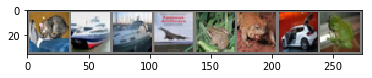

GroundTruth:    cat,  ship,  ship, plane,  frog,  frog,   car,  frog


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images = images[0:examplesCnt]
labels = labels[0:examplesCnt]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % classes[labels[j]] for j in range(examplesCnt)))

In [16]:
# move input to cuda device if available
images = images.to(device)
outputs = net(images)

<b>Predicted Classes from our network:</b>

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ', '.join('%5s' % classes[predicted[j]] for j in range(examplesCnt)))

Predicted:    cat,  ship,  ship, plane,  frog,  frog,   car,  frog


<b>Total Accuracy:</b>

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %2d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 71 %


<b>Class Accuracy:</b>

In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batchSize):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 72 %
Accuracy of   car: 83 %
Accuracy of  bird: 59 %
Accuracy of   cat: 54 %
Accuracy of  deer: 65 %
Accuracy of   dog: 62 %
Accuracy of  frog: 78 %
Accuracy of horse: 74 %
Accuracy of  ship: 82 %
Accuracy of truck: 80 %
